# Camera calibration using CHARUCO

In [2]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg


## 1.  Marker dictionary creation

<IPython.core.display.Javascript object>


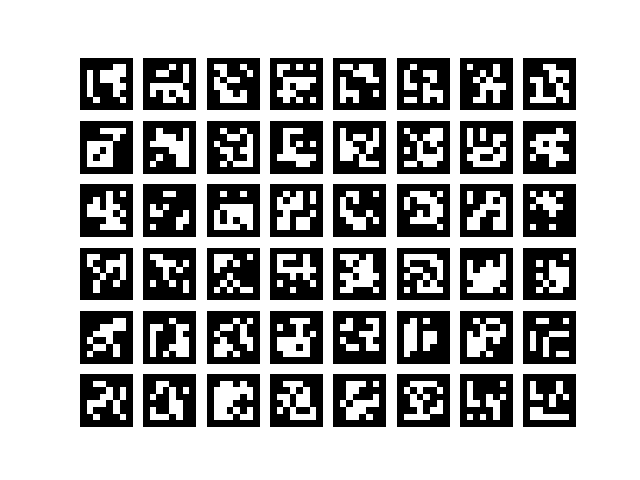

In [3]:
workdir = "_data/calibration/"

aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 8
ny = 6
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig(workdir + "markers.pdf")    
plt.show()
#plt.close()

## 2. Camera pose estimation using CHARUCO chessboard

First, let's create the board.

<IPython.core.display.Javascript object>


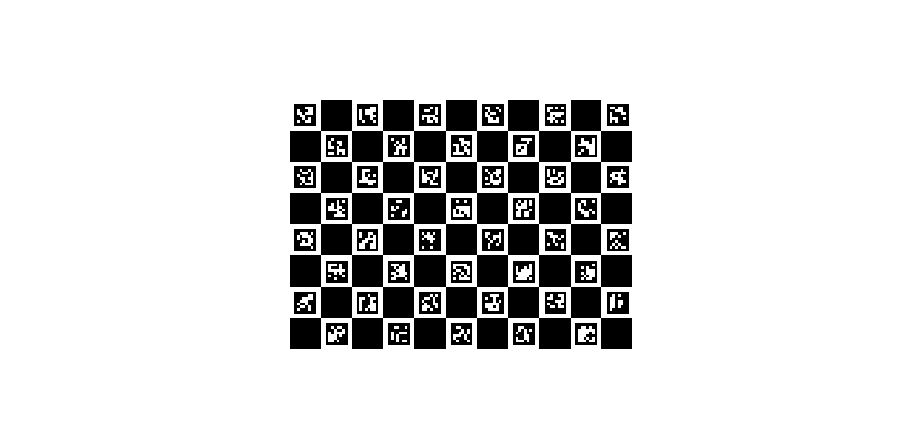

In [4]:
board = aruco.CharucoBoard_create(11, 8, 10, 7, aruco_dict)
imboard = board.draw((500, 500))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(imboard, cmap = mpl.cm.gray, interpolation = "nearest")
ax.axis("off")
plt.savefig(workdir + "chessboard.pdf")    
plt.show()


And take photos of it from multiple angles, for example:

<IPython.core.display.Javascript object>


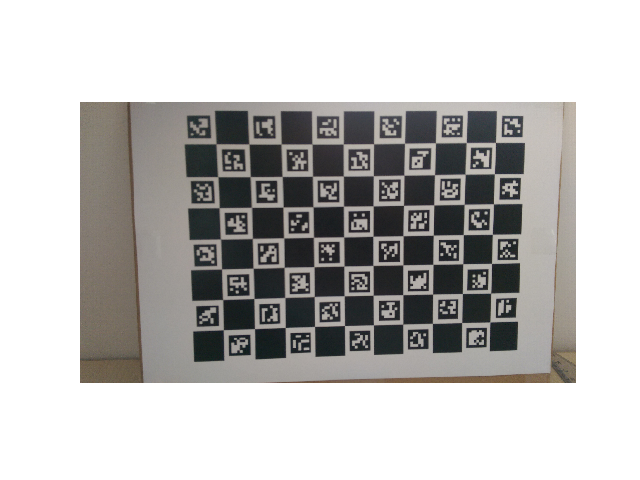

In [5]:
im = PIL.Image.open(workdir + "chess (1).jpg")
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

* The first will detect markers on all the images and.
* The second will proceed the detected markers to estimage the camera calibration data.

In [6]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    
    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        res = cv2.aruco.detectMarkers(gray, aruco_dict)

        if len(res[0])>0:
            res2 = cv2.aruco.interpolateCornersCharuco(res[0],res[1],gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              

        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [9]:
%%time
images = [workdir + f for f in os.listdir(workdir) if f.startswith("chess ")]
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image _data/calibration/chess (14).jpg
=> Processing image _data/calibration/chess (27).jpg
=> Processing image _data/calibration/chess (65).jpg
=> Processing image _data/calibration/chess (10).jpg
=> Processing image _data/calibration/chess (31).jpg
=> Processing image _data/calibration/chess (38).jpg
=> Processing image _data/calibration/chess (13).jpg
=> Processing image _data/calibration/chess (53).jpg
=> Processing image _data/calibration/chess (71).jpg
=> Processing image _data/calibration/chess (35).jpg
=> Processing image _data/calibration/chess (8).jpg
=> Processing image _data/calibration/chess (20).jpg
=> Processing image _data/calibration/chess (60).jpg
=> Processing image _data/calibration/chess (80).jpg
=> Processing image _data/calibration/chess (49).jpg
=> Processing image _data/calibration/chess (45).jpg
=> Processing image _data/calibration/chess (68).jpg
=> Processing image _data/calibration/chess (96).jpg
=> Processing image _da

In [10]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 2000.,    0., imsize[0]/2.],
                                 [    0., 2000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [11]:
%%time
ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)
ret

CAMERA CALIBRATION
CPU times: user 19.9 s, sys: 12.1 s, total: 32 s
Wall time: 8.33 s


In [12]:
mtx

array([[1.92221703e+03, 0.00000000e+00, 1.32287182e+03],
       [0.00000000e+00, 1.91749342e+03, 7.44975483e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [13]:
dist

array([[-3.00293155e+00],
       [-1.27972005e+01],
       [-9.42079150e-04],
       [-4.55859966e-03],
       [ 6.79345142e+01],
       [-3.27053069e+00],
       [-1.09353627e+01],
       [ 6.39080214e+01],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

### Check calibration results

<IPython.core.display.Javascript object>


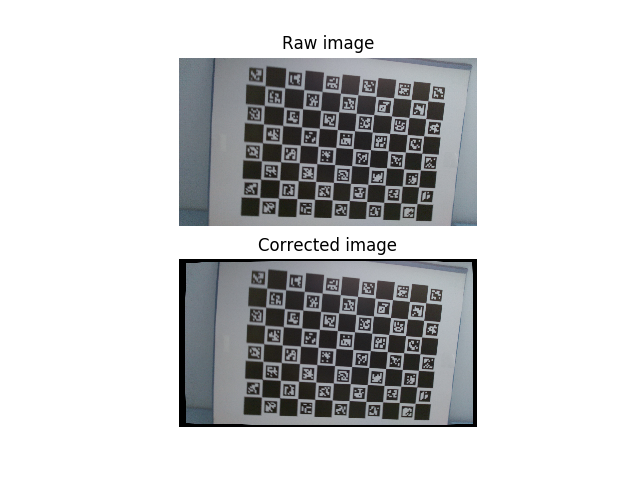

In [17]:
i=24 # select image id
plt.figure()
frame = cv2.imread(workdir + "chess ({0}).jpg".format(i))
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(211)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(212)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

## 3 . Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

<IPython.core.display.Javascript object>


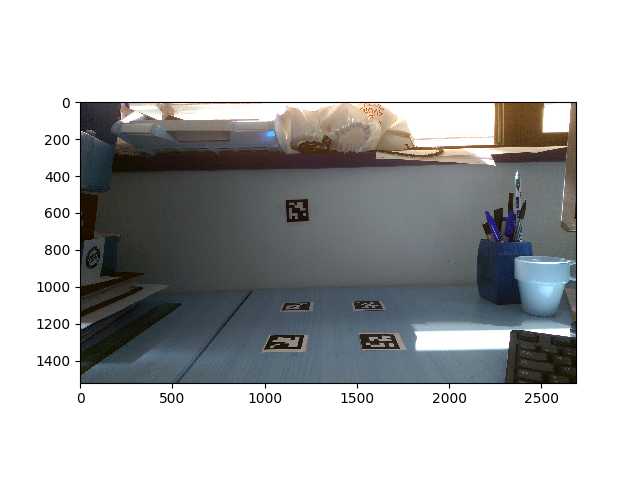

In [18]:
frame = cv2.imread(workdir + "Bureau4.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

## Post processing

In [19]:
%%time

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)


CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 93.9 ms


Very fast processing !

## Results

<IPython.core.display.Javascript object>


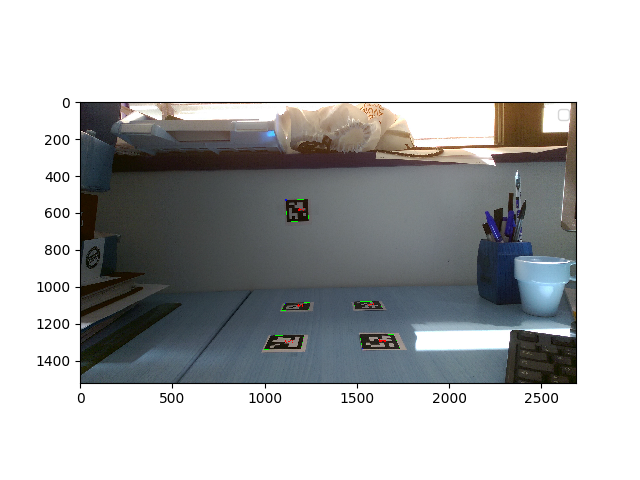

No handles with labels found to put in legend.


In [20]:
conn = np.array([0, 1, 2, 3, 0])
plt.figure()
plt.imshow(frame_markers)
plt.legend()
plt.show()

### Add local axis on each marker

In [21]:
size_of_marker =  0.045 # side lenght of the marker in meter
rvecs,tvecs, trash = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [22]:
tvecs

array([[[-0.04996193,  0.13090217,  0.46302711]],

       [[ 0.06920477,  0.12810409,  0.4556977 ]],

       [[-0.047952  ,  0.11566398,  0.62292158]],

       [[ 0.07540782,  0.11387689,  0.62305052]],

       [[-0.05556319, -0.06070922,  0.7389876 ]]])

In [23]:
rvecs

array([[[ 1.66844355,  0.00787485, -0.04052657]],

       [[ 1.30452234, -1.28803734,  1.11818763]],

       [[ 1.67034939,  0.01101485, -0.0403019 ]],

       [[ 1.67772653, -0.02148337, -0.00857667]],

       [[ 3.22557038, -0.04937676, -0.00538428]]])

In [24]:
length_of_axis = 0.05
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

<IPython.core.display.Javascript object>


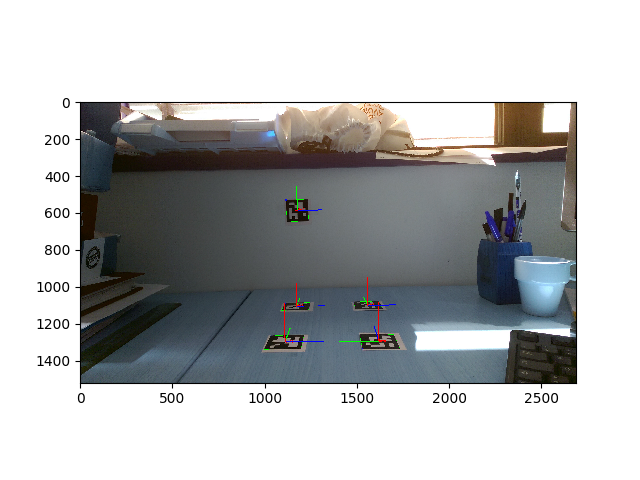

In [25]:
plt.figure()
plt.imshow(imaxis)
plt.show()